### Imports

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import tensorflow as tf
import re
import preprocessor as p
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import ipywidgets
from ipywidgets import interact , interact_manual
from IPython.display import display
import geopandas as gpd

### Feature Engineering

In [13]:
data = pd.read_csv(r'cleaned_data.csv' , index_col = 0)
data.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin
0,2018-12-31 21:45:23.000,2018 has been a poignantly difficult year for ...,neutral,blog,North America,Canada,unknown,15,0,0,0,False
1,2018-12-31 10:04:00.000,RT @StairwayNowhere: In 2018 I've beaten pneum...,neutral,twitter,North America,Canada,female,49,46,54,734,False
2,2018-12-31 04:08:23.000,RT @TheFastestEddie: I need your help to get i...,neutral,twitter,North America,Canada,male,35,46,54,512,True
3,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False
4,2018-12-29 09:14:56.000,Home\n\n> Antineoplastic agents > Antisense Ol...,neutral,blog,North America,United States,unknown,15,0,0,0,False


In [14]:
puncs = string.punctuation

In [15]:
def stage(x):
    l = []
    x = x.lower().split()
    for word in x:
        if re.search(r'sympt',word):
            l.append('Symptom')
        elif re.search(r'diag',word):
            l.append('Diagnose')
        elif re.search(r'treat',word):
            l.append('Treatment')
        elif re.search(r'manage',word):
            l.append('Management')
        else:
            pass
    if (len(l) == 0):
        l.append('Nothing')
            
    l = list(set(l))
    return l

In [16]:
def clean_data(x):
    x = x.lower()
    x = p.clean(x)
    x = re.sub(r'\\n','' ,x)
    x = re.sub(r'\\t','',x)
    x = re.sub(r'\\r','',x)
    x = re.sub(r'\s+',' ',x)
    txt = []
    for char in x:
        if (char not in puncs):
            txt.append(char)
        else:
            txt.append(' ')
    text = ''.join(txt)
    texts = text.split()
    return ' '.join(text for text in texts if (len(text) > 4))

In [17]:
data['clean_data'] = data['Full Text'].apply(clean_data)
data.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin,clean_data
0,2018-12-31 21:45:23.000,2018 has been a poignantly difficult year for ...,neutral,blog,North America,Canada,unknown,15,0,0,0,False,poignantly difficult several young deaths swee...
1,2018-12-31 10:04:00.000,RT @StairwayNowhere: In 2018 I've beaten pneum...,neutral,twitter,North America,Canada,female,49,46,54,734,False,beaten pneumonia beating atrial fibrillation c...
2,2018-12-31 04:08:23.000,RT @TheFastestEddie: I need your help to get i...,neutral,twitter,North America,Canada,male,35,46,54,512,True,donations going jamie mother fighting hodgkins...
3,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False,monday december season giving hophi everyone h...
4,2018-12-29 09:14:56.000,Home\n\n> Antineoplastic agents > Antisense Ol...,neutral,blog,North America,United States,unknown,15,0,0,0,False,antineoplastic agents antisense oligonucleotid...


In [18]:
def lemmatizer(x):
    x = x.split()
    lemma = WordNetLemmatizer()
    lem_words = [lemma.lemmatize(word) for word in x]
    return ' '.join(lem_words)

In [25]:
data['clean_data'] = data['clean_data'].apply(lemmatizer)
data.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin,clean_data
0,2018-12-31 21:45:23.000,2018 has been a poignantly difficult year for ...,neutral,blog,North America,Canada,unknown,15,0,0,0,False,poignantly difficult several young death sweet...
1,2018-12-31 10:04:00.000,RT @StairwayNowhere: In 2018 I've beaten pneum...,neutral,twitter,North America,Canada,female,49,46,54,734,False,beaten pneumonia beating atrial fibrillation c...
2,2018-12-31 04:08:23.000,RT @TheFastestEddie: I need your help to get i...,neutral,twitter,North America,Canada,male,35,46,54,512,True,donation going jamie mother fighting hodgkin l...
3,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False,monday december season giving hophi everyone h...
4,2018-12-29 09:14:56.000,Home\n\n> Antineoplastic agents > Antisense Ol...,neutral,blog,North America,United States,unknown,15,0,0,0,False,antineoplastic agent antisense oligonucleotide...


In [26]:
stage(data['clean_data'][500])

['Diagnose', 'Treatment']

In [27]:
data['Stage'] = data['clean_data'].apply(stage)

In [28]:
data['Stage'] = data['Stage'].apply(lambda x:','.join(x))
data.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin,clean_data,Stage
0,2018-12-31 21:45:23.000,2018 has been a poignantly difficult year for ...,neutral,blog,North America,Canada,unknown,15,0,0,0,False,poignantly difficult several young death sweet...,Nothing
1,2018-12-31 10:04:00.000,RT @StairwayNowhere: In 2018 I've beaten pneum...,neutral,twitter,North America,Canada,female,49,46,54,734,False,beaten pneumonia beating atrial fibrillation c...,Nothing
2,2018-12-31 04:08:23.000,RT @TheFastestEddie: I need your help to get i...,neutral,twitter,North America,Canada,male,35,46,54,512,True,donation going jamie mother fighting hodgkin l...,Nothing
3,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False,monday december season giving hophi everyone h...,Diagnose
4,2018-12-29 09:14:56.000,Home\n\n> Antineoplastic agents > Antisense Ol...,neutral,blog,North America,United States,unknown,15,0,0,0,False,antineoplastic agent antisense oligonucleotide...,Nothing


In [29]:
data_stage = data[data['Stage'] != 'Nothing']
data_stage.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin,clean_data,Stage
3,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False,monday december season giving hophi everyone h...,Diagnose
6,2018-12-28 11:43:37.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,39,46,54,571,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose
7,2018-12-27 19:18:01.000,RT @craytusjones: Sorry if I'm a bit philosoph...,neutral,twitter,North America,Canada,female,36,46,54,537,True,sorry philosophical today celebrated since dia...,Diagnose
9,2018-12-25 13:15:55.478,What we need is some more time. \nHelp! \nI'm ...,neutral,forum,North America,United States,unknown,43,0,0,0,False,being followed paranoid going leave hirofumi h...,Treatment
11,2018-12-24 14:50:23.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,36,46,54,524,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose


In [30]:
# data_stage.to_csv('data_stage.csv' , index = False)

In [31]:
data_stage = pd.read_csv(r'data_stage.csv')
data_stage.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin,clean_data,Stage
0,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False,monday december season giving hophi everyone h...,Diagnose
1,2018-12-28 11:43:37.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,39,46,54,571,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose
2,2018-12-27 19:18:01.000,RT @craytusjones: Sorry if I'm a bit philosoph...,neutral,twitter,North America,Canada,female,36,46,54,537,True,sorry philosophical today celebrated since dia...,Diagnose
3,2018-12-25 13:15:55.478,What we need is some more time. \nHelp! \nI'm ...,neutral,forum,North America,United States,unknown,43,0,0,0,False,being followed paranoid going leave hirofumi h...,Treatment
4,2018-12-24 14:50:23.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,36,46,54,524,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose


In [32]:
# data_stage.to_csv('data_stage.csv' , index = False)

In [33]:
data_stage = pd.read_csv(r'data_stage.csv')
data_stage.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin,clean_data,Stage
0,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False,monday december season giving hophi everyone h...,Diagnose
1,2018-12-28 11:43:37.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,39,46,54,571,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose
2,2018-12-27 19:18:01.000,RT @craytusjones: Sorry if I'm a bit philosoph...,neutral,twitter,North America,Canada,female,36,46,54,537,True,sorry philosophical today celebrated since dia...,Diagnose
3,2018-12-25 13:15:55.478,What we need is some more time. \nHelp! \nI'm ...,neutral,forum,North America,United States,unknown,43,0,0,0,False,being followed paranoid going leave hirofumi h...,Treatment
4,2018-12-24 14:50:23.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,36,46,54,524,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose


In [34]:
stages = ['Diagnose', 'Management', 'Symptom', 'Treatment']
def sort_stage(x):
    x = x.split(',')
    x = sorted(x)
    if (len(x) != 4):
        i = 0
        while(i<3):
            try:
                if (x[i] != stages[i]):
                    x.insert(i , 'Z')
            except:
                pass
            i+=1
        n = 4 - len(x)
        x += ['Z'] *n
    return x

In [35]:
data_stage['Stages'] = data_stage['Stage'].apply(sort_stage)
data_stage.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Gender,Impact,Percentage Female,Percentage Male,Twitter Reach,is_hodgkin,clean_data,Stage,Stages
0,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,unknown,45,0,0,0,False,monday december season giving hophi everyone h...,Diagnose,"[Diagnose, Z, Z, Z]"
1,2018-12-28 11:43:37.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,39,46,54,571,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose,"[Diagnose, Z, Z, Z]"
2,2018-12-27 19:18:01.000,RT @craytusjones: Sorry if I'm a bit philosoph...,neutral,twitter,North America,Canada,female,36,46,54,537,True,sorry philosophical today celebrated since dia...,Diagnose,"[Diagnose, Z, Z, Z]"
3,2018-12-25 13:15:55.478,What we need is some more time. \nHelp! \nI'm ...,neutral,forum,North America,United States,unknown,43,0,0,0,False,being followed paranoid going leave hirofumi h...,Treatment,"[Z, Z, Z, Treatment]"
4,2018-12-24 14:50:23.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,unknown,36,46,54,524,False,gunnar diagnosed acute lymphoblastic leukemia ...,Diagnose,"[Diagnose, Z, Z, Z]"


In [36]:
df_stages = pd.DataFrame(data_stage['Stages'].tolist(),columns = ['Diagnose','Management','Symptom','Treatment'])

In [37]:
final_df = pd.concat([data_stage,df_stages] , axis = 1)
final_df.drop(['Stage','is_hodgkin','Gender'] , axis=1,inplace=True)
final_df.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Impact,Percentage Female,Percentage Male,Twitter Reach,clean_data,Stages,Diagnose,Management,Symptom,Treatment
0,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",neutral,blog,North America,United States,45,0,0,0,monday december season giving hophi everyone h...,"[Diagnose, Z, Z, Z]",Diagnose,Z,Z,Z
1,2018-12-28 11:43:37.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,39,46,54,571,gunnar diagnosed acute lymphoblastic leukemia ...,"[Diagnose, Z, Z, Z]",Diagnose,Z,Z,Z
2,2018-12-27 19:18:01.000,RT @craytusjones: Sorry if I'm a bit philosoph...,neutral,twitter,North America,Canada,36,46,54,537,sorry philosophical today celebrated since dia...,"[Diagnose, Z, Z, Z]",Diagnose,Z,Z,Z
3,2018-12-25 13:15:55.478,What we need is some more time. \nHelp! \nI'm ...,neutral,forum,North America,United States,43,0,0,0,being followed paranoid going leave hirofumi h...,"[Z, Z, Z, Treatment]",Z,Z,Z,Treatment
4,2018-12-24 14:50:23.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,neutral,twitter,North America,Canada,36,46,54,524,gunnar diagnosed acute lymphoblastic leukemia ...,"[Diagnose, Z, Z, Z]",Diagnose,Z,Z,Z


In [38]:
le = LabelEncoder()
final_df[['Diagnose','Management','Symptom','Treatment','Sentiment','Page Type']] = \
    final_df[['Diagnose','Management','Symptom','Treatment','Sentiment','Page Type']].apply(le.fit_transform)
final_df.head()

,Date,Full Text,Sentiment,Page Type,Continent,Country,Impact,Percentage Female,Percentage Male,Twitter Reach,clean_data,Stages,Diagnose,Management,Symptom,Treatment
0,2018-12-31 00:00:00.000,"Monday, December 31, 2018\n\nSeason's Giving B...",1,0,North America,United States,45,0,0,0,monday december season giving hophi everyone h...,"[Diagnose, Z, Z, Z]",0,1,1,1
1,2018-12-28 11:43:37.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,1,4,North America,Canada,39,46,54,571,gunnar diagnosed acute lymphoblastic leukemia ...,"[Diagnose, Z, Z, Z]",0,1,1,1
2,2018-12-27 19:18:01.000,RT @craytusjones: Sorry if I'm a bit philosoph...,1,4,North America,Canada,36,46,54,537,sorry philosophical today celebrated since dia...,"[Diagnose, Z, Z, Z]",0,1,1,1
3,2018-12-25 13:15:55.478,What we need is some more time. \nHelp! \nI'm ...,1,1,North America,United States,43,0,0,0,being followed paranoid going leave hirofumi h...,"[Z, Z, Z, Treatment]",1,1,1,0
4,2018-12-24 14:50:23.000,RT @HeroesandCops: HERO Gunnar was was diagnos...,1,4,North America,Canada,36,46,54,524,gunnar diagnosed acute lymphoblastic leukemia ...,"[Diagnose, Z, Z, Z]",0,1,1,1


In [39]:
final_df.to_csv('final_df.csv')

In [40]:
diagnose_text = final_df[final_df['Diagnose'] == 1]['clean_data']
management_text = final_df[final_df['Management'] == 1]['clean_data']
symptom_text = final_df[final_df['Symptom'] == 1]['clean_data']
treatment_text = final_df[final_df['Treatment'] == 1]['clean_data']

### Diagnose

In [41]:
diagnose_text = diagnose_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|online' , '')

C:\Temp\ipykernel_8608\3204097465.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  diagnose_text = diagnose_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|online' , '')


In [42]:
diagnose_text.str.contains('blank').value_counts()

False    545
Name: clean_data, dtype: int64

In [43]:
cv_diag  = CountVectorizer(stop_words = 'english', ngram_range = (2,2))
cv_diagnose = cv_diag.fit_transform(diagnose_text)

lda_diagnose = LatentDirichletAllocation(n_components = 10)
lda_diagnose.fit(cv_diagnose)

for i in range(10):
    topic = lda_diagnose.components_[i]
    print(f'Topic - {i}')
    top_words = topic.argsort()[-10:]
    for index in top_words:
        print(cv_diag.get_feature_names_out()[index])
    print('\n')

Topic - 0
lymphocytic leukemia
needed vaccinate
ativan injection
number needed
status epilepticus
adverse reaction
forum gratis
cervical cancer
adverse effect
international unit


Topic - 1
levitra prostata
prescription cialis
viagra cialis
liver disease
glyphosate herbicide
biaxin biaxin
acute lymphoblastic
lymphoblastic leukemia
generic viagra
methotrexate methotrexate


Topic - 2
tomeh acute
viagra cialis
vegetal shear
fedex corporation
lymphoblastic leukemia
acute lymphoblastic
endometrial cancer
erectile dysfunction
dorsalizing activity
cortical rotation


Topic - 3
counter naltrexone
naltrexone paypal
naltrexone tablet
fedex delivery
clinical trial
discount naltrexone
naltrexone overnight
naltrexone naltrexone
blood pressure
naltrexone internet


Topic - 4
purinethol order
monsanto roundup
promoter activity
purinethol prescription
purinethol overnight
drinking water
order purinethol
purinethol cheap
cheap purinethol
purinethol purinethol


Topic - 5
lymphocytic leukemia
adverse e

In [44]:
# tfidf_diag = TfidfVectorizer(max_features = 10000 , stop_words = 'english',ngram_range=(2,2))
# tf_diag = tfidf_diag.fit_transform(diagnose_text).toarray()

sum_words_diag = cv_diagnose.sum(axis = 0)
# sum_words_diag = tf_diag.sum(axis = 0)
words_freq_diag = [(word , sum_words_diag[0,idx]) for word ,idx in cv_diag.vocabulary_.items()]
# words_freq_diag = [(word , sum_words_diag[idx]) for word ,idx in tfidf_diag.vocabulary_.items()]
words_freq_diag = sorted(words_freq_diag , key = lambda x:x[1], reverse = True)
frequency_diag  = pd.DataFrame(words_freq_diag , columns = ['word' , 'freq'])

frequency_diag.head()

,word,freq
0,hodgkin lymphoma,222
1,ativan injection,160
2,methotrexate methotrexate,155
3,blood pressure,124
4,clinical trial,123


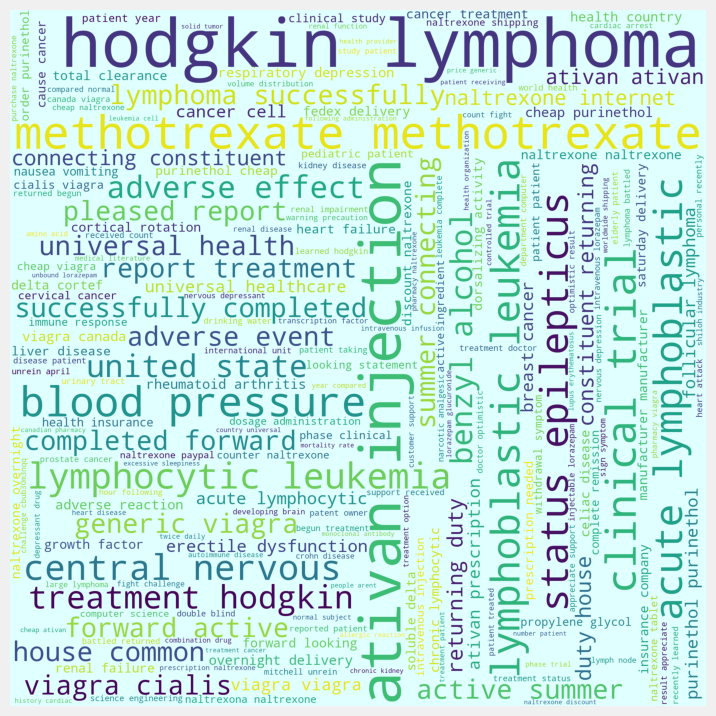

In [47]:
wordcloud_diag = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq_diag))

plt.style.use('fivethirtyeight')
plt.figure(figsize = (8,15))
plt.axis('off')
plt.imshow(wordcloud_diag)
plt.show()

### Management

In [48]:
management_text = management_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|online' , '')

management_text.str.contains('blank').value_counts()

C:\Temp\ipykernel_8608\3145523173.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  management_text = management_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|online' , '')


False    1006
Name: clean_data, dtype: int64

In [49]:
cv_mng  = CountVectorizer(stop_words = 'english', ngram_range = (2,2))
cv_mngnt = cv_mng.fit_transform(management_text)

lda_mngnt = LatentDirichletAllocation(n_components = 5)
lda_mngnt.fit(cv_mngnt)

for i in range(5):
    topic = lda_mngnt.components_[i]
    print(f'Topic - {i}')
    top_words = topic.argsort()[-10:]
    for index in top_words:
        print(cv_mng.get_feature_names_out()[index])
    print('\n')

Topic - 0
manufacturer manufacturer
acute lymphoblastic
malignant brain
viagra cialis
cialis viagra
systematic review
blood pressure
united state
hodgkin lymphoma
brain tumor


Topic - 1
order purinethol
purinethol cheap
united state
acute lymphoblastic
lymphoblastic leukemia
cheap purinethol
blood pressure
purinethol purinethol
hodgkin lymphoma
clinical trial


Topic - 2
cancer cell
breast cancer
follicular lymphoma
naltrexone naltrexone
lymphoblastic leukemia
acute lymphoblastic
generic viagra
naltrexone internet
hodgkin lymphoma
blood pressure


Topic - 3
constituent returning
pleased report
connecting constituent
report treatment
completed forward
successfully completed
methotrexate methotrexate
house common
treatment hodgkin
hodgkin lymphoma


Topic - 4
ativan injection
central nervous
multiple myeloma
celiac disease
viagra viagra
diagnosed acute
blood pressure
hodgkin lymphoma
lymphoblastic leukemia
acute lymphoblastic




In [50]:
# tfidf_manage = TfidfVectorizer(max_features = 10000 , stop_words = 'english',ngram_range=(2,2))
# tf_manage = tfidf_manage.fit_transform(management_text).toarray()

sum_words_manage = cv_mngnt.sum(axis = 0)
# sum_words_manage = tf_manage.sum(axis = 0)
words_freq_manage = [(word , sum_words_manage[0,idx]) for word ,idx in cv_mng.vocabulary_.items()]
# words_freq_manage = [(word , sum_words_manage[idx]) for word ,idx in tfidf_manage.vocabulary_.items()]
words_freq_manage = sorted(words_freq_manage , key = lambda x:x[1], reverse = True)
frequency_manage  = pd.DataFrame(words_freq_manage , columns = ['word' , 'freq'])

frequency_manage.head()

,word,freq
0,hodgkin lymphoma,400
1,blood pressure,308
2,acute lymphoblastic,247
3,lymphoblastic leukemia,235
4,clinical trial,159


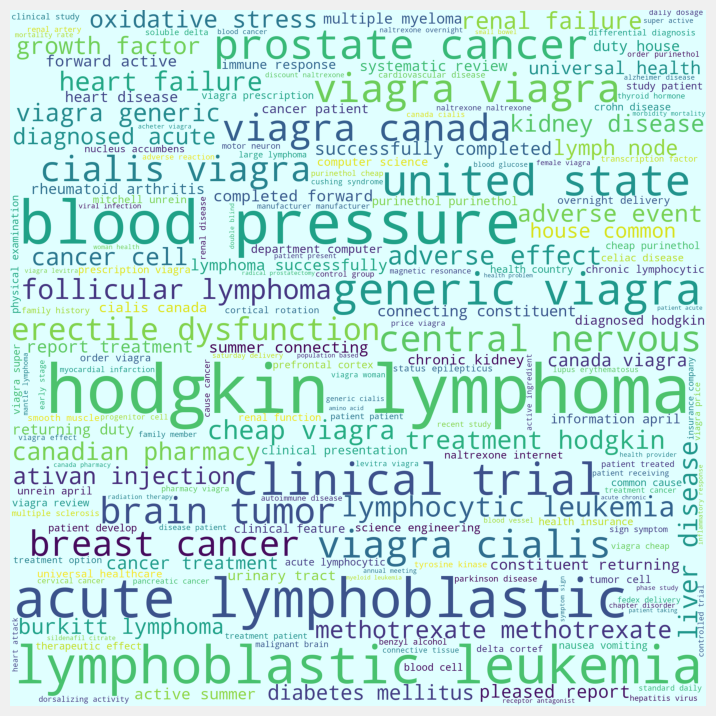

In [51]:
wordcloud_manage = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq_manage))

plt.style.use('fivethirtyeight')
plt.figure(figsize = (8,15))
plt.axis('off')
plt.imshow(wordcloud_manage)
plt.show()

### Symptom

In [52]:
symptom_text = symptom_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|field|online|forward|' ,
                                        '')

symptom_text.str.contains('blank').value_counts()

C:\Temp\ipykernel_8608\2064786075.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  symptom_text = symptom_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|field|online|forward|' ,


False    738
Name: clean_data, dtype: int64

In [53]:
cv_sym  = CountVectorizer(stop_words = 'english', ngram_range = (2,2))
cv_symptom = cv_sym.fit_transform(symptom_text)

lda_symptom = LatentDirichletAllocation(n_components = 10)
lda_symptom.fit(cv_symptom)

for i in range(10):
    topic = lda_symptom.components_[i]
    print(f'Topic - {i}')
    top_words = topic.argsort()[-10:]
    for index in top_words:
        print(cv_sym.get_feature_names_out()[index])
    print('\n')

Topic - 0
follicular lymphoma
diagnosed hodgkin
cancer cell
acute lymphoblastic
fedex corporation
bendamustine rituximab
blood pressure
insulin resistance
breast cancer
hodgkin lymphoma


Topic - 1
viagra cialis
fruit veggie
transcription factor
herbal viagra
spontaneous tumor
propylene glycol
ativan injection
disseminated lymphoma
promoter activity
hodgkin lymphoma


Topic - 2
returning duty
constituent returning
report treatment
active summer
summer connecting
lymphoma successfully
connecting constituent
house common
treatment hodgkin
hodgkin lymphoma


Topic - 3
lymphoblastic leukemia
shiloh industry
oxidative stress
international unit
patent owner
hodgkin lymphoma
blood pressure
multiple myeloma
naltrexone internet
manufacturer manufacturer


Topic - 4
positive lymphoma
diffuse large
large lymphoma
diagnosed hodgkin
viagra canada
monsanto roundup
diagnosed acute
lymphoblastic leukemia
acute lymphoblastic
hodgkin lymphoma


Topic - 5
cheap viagra
medical school
phase clinical
geneti

In [54]:
# tfidf_symptom = TfidfVectorizer(max_features = 10000 , stop_words = 'english',ngram_range=(2,2))
# tf_symptom = tfidf_manage.fit_transform(symptom_text).toarray()

sum_words_sym = cv_symptom.sum(axis = 0)
# sum_words_sym = tf_symptom.sum(axis = 0)
words_freq_sym = [(word , sum_words_sym[0,idx]) for word ,idx in cv_sym.vocabulary_.items()]
# words_freq_sym = [(word , sum_words_sym[idx]) for word ,idx in tfidf_symptom.vocabulary_.items()]
words_freq_sym = sorted(words_freq_sym , key = lambda x:x[1], reverse = True)
frequency_sym = pd.DataFrame(words_freq_sym , columns = ['word' , 'freq'])

frequency_sym.head()

,word,freq
0,hodgkin lymphoma,340
1,acute lymphoblastic,172
2,lymphoblastic leukemia,168
3,clinical trial,130
4,united state,113


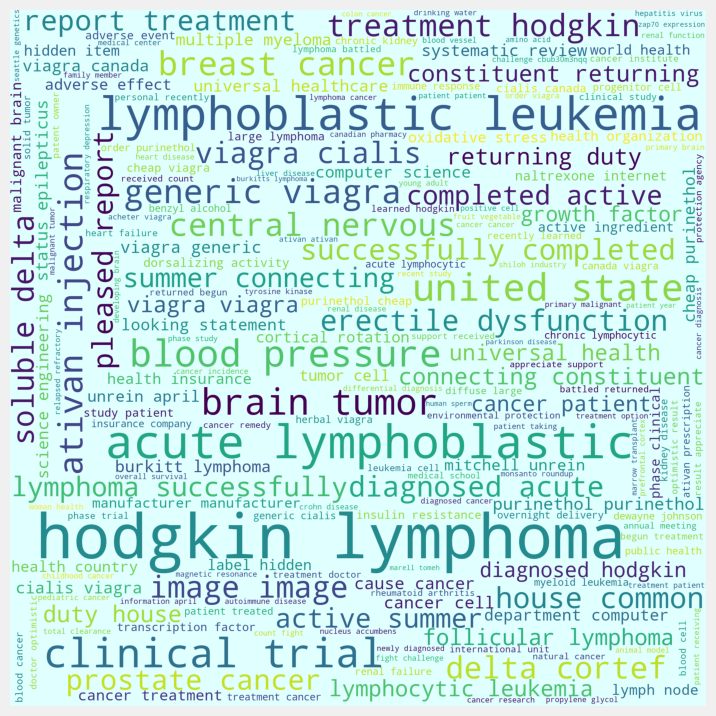

In [55]:
wordcloud_sym = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq_sym))

plt.style.use('fivethirtyeight')
plt.figure(figsize = (8,15))
plt.axis('off')
plt.imshow(wordcloud_sym)
plt.show()

### Treatment

In [56]:
treatment_text = treatment_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|field|online|forward|' ,
                                        '')

treatment_text.str.contains('blank').value_counts()

C:\Temp\ipykernel_8608\1809947550.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  treatment_text = treatment_text.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|field|online|forward|' ,


False    245
Name: clean_data, dtype: int64

In [57]:
cv_treat  = CountVectorizer(stop_words = 'english', ngram_range = (2,2))
cv_treatment = cv_treat.fit_transform(treatment_text)

lda_treat = LatentDirichletAllocation(n_components = 10)
lda_treat.fit(cv_treatment)

lda_treat_topics = dict()
for i in range(10):
    single_topic = []
    topic = lda_treat.components_[i]
#     print(f'Topic - {i}')
    top_words = topic.argsort()[-10:]
    for index in top_words:
        single_topic.append(cv_treat.get_feature_names_out()[index])
    lda_treat_topics[f'Topic_{i+1}'] =single_topic

pd.DataFrame(lda_treat_topics)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,andrew dunsmore,local rushed,viagra generic,widely herbicide,water fluoridation,acute lymphoblastic,blood pressure,thank supporting,control study,lymphoblastic leukemia
1,musical ability,lawrence walked,glyphosate based,glyphosate widely,acute lymphoblastic,lymphoblastic leukemia,diffuse large,allowed present,zoster virus,case state
2,jessa vokey,walked local,ingredient roundup,level glyphosate,lymphoblastic leukemia,share following,leukemia year,africa cancer,varicella zoster,lymphoma using
3,recruiting musical,rushed intensive,active ingredient,science nasdaq,fluoride level,retweet latest,premarin prescription,genetics burkitt,thimerosal containing,master herbicide
4,musician physician,intensive morning,cause cancer,cause cancer,fluoridated water,latest dewayne,viagra sample,research thing,containing vaccine,cheapest viagra
5,physician medical,child lawrence,generic viagra,environmental protection,roundup cancer,dewayne share,herbal viagra,thing funding,influenza vaccine,diagnosed hodgkin
6,school recruiting,glyphosate herbicide,viagra generika,protection agency,paiement cialis,following diagnosis,diagnosed acute,funding allowed,measles mumps,hodgkin lymphoma
7,peter jackson,diagnosed acute,diagnosed hodgkin,gilead science,cancer causing,viagra methamphetamine,hodgkin lymphoma,saharan africa,mumps rubella,fallow master
8,medical school,lymphoblastic leukemia,dewayne johnson,toxic algae,republic ireland,diagnosis hodgkin,lymphoblastic leukemia,cancer commonly,hodgkin lymphoma,garlon fallow
9,hodgkin lymphoma,acute lymphoblastic,hodgkin lymphoma,fedex corporation,drinking water,hodgkin lymphoma,acute lymphoblastic,burkitt lymphoma,adverse event,viagra cheapest


In [58]:
# tfidf_treat = TfidfVectorizer(max_features = 10000 , stop_words = 'english',ngram_range=(2,2))
# tf_treat = tfidf_manage.fit_transform(treatment_text).toarray()

sum_words_treat = cv_treatment.sum(axis = 0)
# sum_words_treat = tf_treat.sum(axis = 0)
words_freq_treat = [(word , sum_words_treat[0,idx]) for word ,idx in cv_treat.vocabulary_.items()]
# words_freq_treat = [(word , sum_words_treat[idx]) for word ,idx in tfidf_treat.vocabulary_.items()]
words_freq_treat = sorted(words_freq_treat , key = lambda x:x[1], reverse = True)
frequency_treat = pd.DataFrame(words_freq_treat , columns = ['word' , 'freq'])

frequency_treat.head()

,word,freq
0,hodgkin lymphoma,120
1,acute lymphoblastic,78
2,lymphoblastic leukemia,72
3,diagnosed acute,50
4,diagnosed hodgkin,42


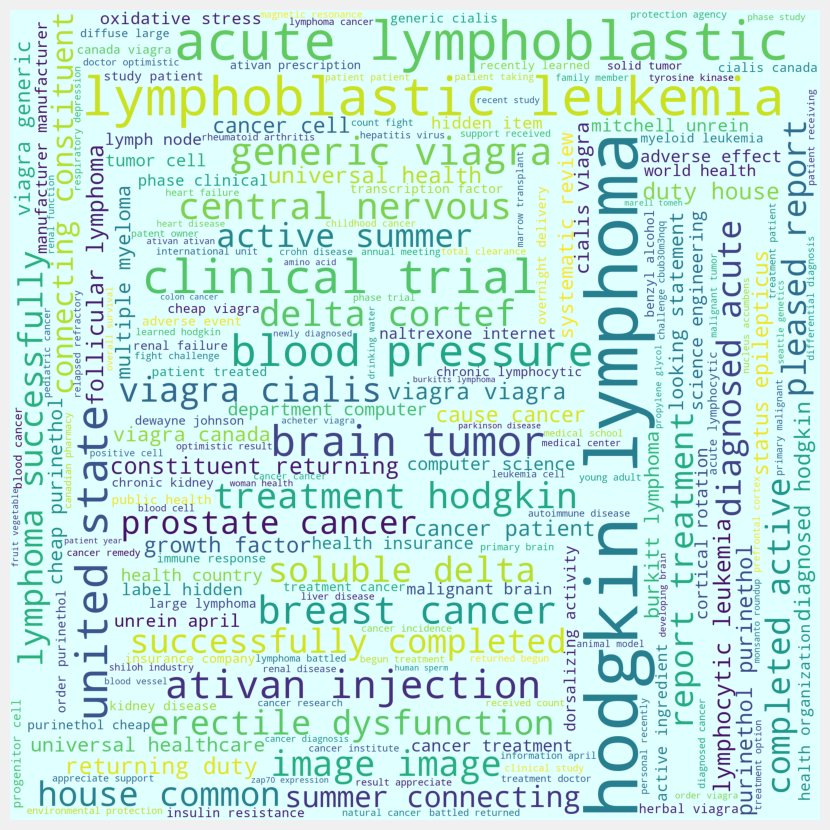

In [59]:
wordcloud_treat = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq_sym))

plt.style.use('fivethirtyeight')
plt.figure(figsize = (12,10))
plt.axis('off')
plt.imshow(wordcloud_treat)
plt.show()

### All Stages

In [60]:
clean_data = data_stage['clean_data']

In [61]:
clean_data = clean_data.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|field|online|\
                                            forward|united|state|viagra' ,
                                        '')

clean_data.str.contains('viagra').value_counts()

C:\Temp\ipykernel_8608\3512934328.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_data = clean_data.str.replace(r'partial|target|complex|blank|nofollow|class|onclick|postlink|field|online|\


False    1565
Name: clean_data, dtype: int64

In [62]:
cv  = CountVectorizer(stop_words = 'english', ngram_range = (2,2))
words = cv.fit_transform(clean_data)

lda = LatentDirichletAllocation(n_components = 10)
lda.fit(words)

for i in range(10):
    topic = lda.components_[i]
    print(f'Topic - {i}')
    top_words = topic.argsort()[-10:]
    for index in top_words:
        print(cv.get_feature_names_out()[index])
    print('\n')

Topic - 0
lymphocytic leukemia
ativan prescription
ativan ativan
benzyl alcohol
central nervous
blood pressure
acute lymphoblastic
lymphoblastic leukemia
status epilepticus
ativan injection


Topic - 1
pediatric cancer
primary brain
primary malignant
diagnosed hodgkin
central nervous
malignant brain
pro cancer
blood pressure
hodgkin lymphoma
brain tumor


Topic - 2
order purinethol
celiac disease
purinethol cheap
hidden item
label hidden
pro cancer
cheap purinethol
purinethol purinethol
blood pressure
image image


Topic - 3
clinical trial
chronic kidney
clinical presentation
international unit
cervical cancer
adverse effect
multiple myeloma
pro cancer
blood pressure
hodgkin lymphoma


Topic - 4
cancer cell
cause cancer
health insurance
insurance company
hodgkin lymphoma
health country
universal healthcare
pro cancer
universal health
blood pressure


Topic - 5
follicular lymphoma
pro cancer
naltrexone naltrexone
adverse effect
clinical trial
manufacturer manufacturer
generic cialis
hod

In [63]:
# tfidf = TfidfVectorizer(max_features = 10000 , stop_words = 'english',ngram_range=(2,2))
# tf_words = tfidf.fit_transform(clean_data).toarray()

sum_words = words.sum(axis = 0)
# sum_words = tf_words.sum(axis = 0)
words_freq = [(word , sum_words[0,idx]) for word ,idx in cv.vocabulary_.items()]
# words_freq = [(word , sum_words[idx]) for word ,idx in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq , key = lambda x:x[1], reverse = True)
frequency = pd.DataFrame(words_freq , columns = ['word' , 'freq'])

frequency.head()

,word,freq
0,blood pressure,678
1,hodgkin lymphoma,595
2,pro cancer,403
3,acute lymphoblastic,307
4,lymphoblastic leukemia,297


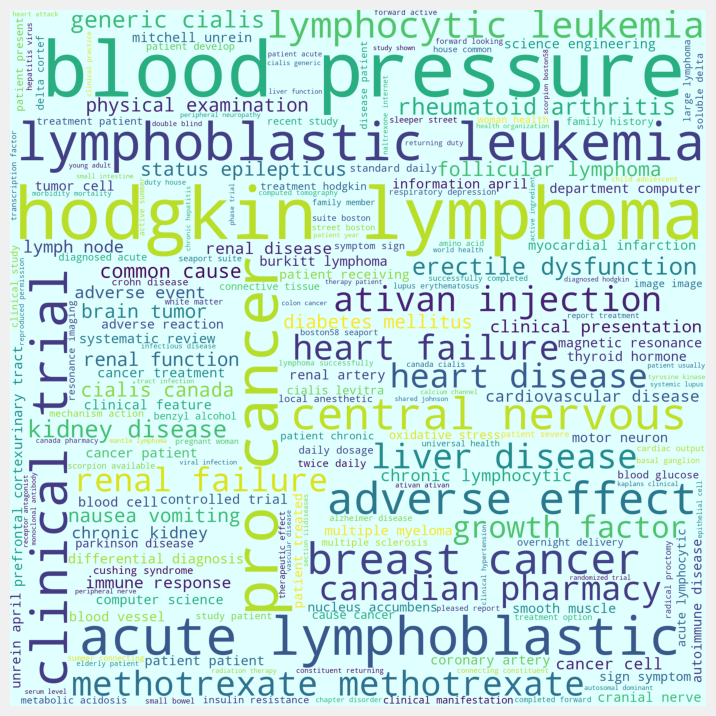

In [64]:
wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize = (8,15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [65]:
nltk.data.path

['C:\\Users\\hrushikesh gowda/nltk_data',
 'D:\\Anaconda3\\envs\\myenv\\nltk_data',
 'D:\\Anaconda3\\envs\\myenv\\share\\nltk_data',
 'D:\\Anaconda3\\envs\\myenv\\lib\\nltk_data',
 'C:\\Users\\hrushikesh gowda\\AppData\\Roaming\\nltk_data',
 'C:\\nltk_data',
 'D:\\nltk_data',
 'E:\\nltk_data']

In [ ]:
# nltk.download('vader_lexicon', download_dir = r'D:\Anaconda3\envs\nlp\nltk_data')

In [ ]:
sid= SentimentIntensityAnalyzer()

In [ ]:
def polarity(x):
    pol = sid.polarity_scores(x)
    pol = pol['compound']
#     if pol<0:
#         return 0
#     else:
#         return 1
    return pol

In [ ]:
data_stage['Polarity'] = data_stage['clean_data'].apply(polarity)
data_stage.head()

In [ ]:
data_stage['Continent'].unique()

### Interactive

In [ ]:
stages = ['Diagnose', 'Treatment','Management','Symptom','All']
ldas = {'Diagnose':lda_diagnose,'Treatment':lda_treat,'Management':lda_mngnt,'Symptom':lda_symptom,'All':lda}
cvs = {'Diagnose':cv_diag,'Treatment':cv_treat,'Management':cv_mng,'Symptom':cv_sym,'All':cv}
countries = ['North America', 'Europe', 'Asia', 'Australasia']
wordclouds = {'Diagnose':wordcloud_diag,'Treatment':wordcloud_treat,'Management':wordcloud_manage,
              'Symptom':wordcloud_sym,'All':wordcloud}
Topic = [False,True]
WordCloud = [False,True]
WorldMap = [False,True]
countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Croatia',
       'Czechia', 'Estonia', 'France', 'Germany', 'Greece', 'India',
       'Indonesia', 'Italy', 'Japan', 'Moldova', 'Netherlands', 'New Zealand',
       'China', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Saudi Arabia', 'Slovenia', 'Switzerland', 'United Kingdom',
       'United States of America']
counts = data_stage.groupby('Country')['clean_data'].agg('count').tolist()
polarities = data_stage.groupby('Country')['Polarity'].agg('mean').tolist()
impacts = data_stage.groupby('Country')['Impact'].agg('mean').tolist()
twitter_reach = data_stage.groupby('Country')['Twitter Reach'].agg('mean').tolist()
map_value = ['counts','polarity','impact','twitter_reach']

In [ ]:
map_data = pd.DataFrame({'country':countries,'counts':counts,'polarity':polarities,
                         'impact':impacts,'twitter_reach':twitter_reach})
    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world=world.merge(map_data,left_on='name',right_on='country',how='outer')

In [ ]:
def plot_map(col):
    
    base=world.boundary.plot(figsize=(30,30),edgecolor='black')

    world.plot(ax=base,column=col, figsize=(20,10),legend=True,legend_kwds={'label': f'{col} of data according to their country',
                                                                            'orientation':"horizontal"},
               missing_kwds={'color': 'lightgrey'},cmap='RdYlGn_r')
    plt.axis('off')
    plt.show()

In [ ]:
# pd.set_option('display.max_rows',None)

In [ ]:
@interact_manual

def NHL(topic = Topic,wordcloud = WordCloud,worldmap=WorldMap,map_value = map_value,
        stage_for_topic = stages,n_topic = range(1,11)):
    print('One of them must be True')
    if(topic):
        if (stage_for_topic == 'Management'):
            n_topic = 5
        else:
            pass
        topics = dict()
        for i in range(n_topic):
            single_topic = []
            topic = ldas[stage_for_topic].components_[i]
            top_words = topic.argsort()[-10:]
            for index in top_words:
                single_topic.append(cvs[stage_for_topic].get_feature_names_out()[index])
            topics[f'Topic_{i+1}'] = single_topic
            
        display(pd.DataFrame(topics))
    
    if(wordcloud):
        print("Showing WordCloud")
        plt.style.use('fivethirtyeight')
        plt.figure(figsize = (12,8))
        plt.axis('off')
        plt.imshow(wordclouds[stage_for_topic])
        plt.show()
        
    if (worldmap):
        plot_map(map_value)